# Skin Disease Detection using MobileNetV2
![skin-disease-image](https://pub.mdpi-res.com/processes/processes-11-01003/article_deploy/html/images/processes-11-01003-g001.png?1679885550)

### About:

A skin condition, also known as a cutaneous condition, is any medical condition that affects the integumentary system—the organ system that encloses the body and includes skin, nails, and related muscle and glands. The major function of this system is as a barrier against the external environment.

Conditions of the human integumentary system constitute a broad spectrum of diseases, also known as dermatoses, as well as many nonpathologic states (like, in certain circumstances, melanonychia and racquet nails). While only a small number of skin diseases account for most visits to the physician, thousands of skin conditions have been described. Classification of these conditions often presents many nosological challenges, since underlying causes and pathogenetics are often unknown. Therefore, most current textbooks present a classification based on location (for example, conditions of the mucous membrane), morphology (chronic blistering conditions), cause (skin conditions resulting from physical factors), and so on.

Reference -> Wikipedia: https://en.wikipedia.org/wiki/Skin_condition


### Proposed work:

In this project, we build a Skin Disease Detection model using MobileNetV2 as the backbone.
The model is trained in three progressive phases to gradually improve its performance:

✅ Phase 1: Train only the top classifier layers while keeping all base layers frozen.

✅ Phase 2: Unfreeze a small portion of deeper layers and fine-tune them.

✅ Phase 3: Unfreeze more layers for deeper fine-tuning and further improvement.

Throughout all phases, a Learning Rate Scheduler is used to dynamically adjust the learning rate, ensuring stable convergence and better generalization. 🚀
This careful phase-wise unfreezing strategy leads to a powerful and efficient model for detecting different types of skin diseases.

## -> Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
import os

In [2]:
train_dir = "/kaggle/input/skin-disease-data/skin_dataset/train"
test_dir = "/kaggle/input/skin-disease-data/skin_dataset/test"

## -> Image Pre-processing

In [3]:
# Image size and batch size
img_size = (224, 224)
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  
    width_shift_range=0.4,  
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Check class labels to ensure proper mapping
print(train_generator.class_indices)

Found 377 images belonging to 5 classes.
Found 101 images belonging to 5 classes.
{'Atopic Dermatitis': 0, 'Melanoma': 1, 'Squamous cell carcinoma': 2, 'Tinea Ringworm Candidiasis': 3, 'Vascular lesion': 4}


### > Class weights calculation 

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from your data generator
class_indices = train_generator.class_indices  

# Get labels for each sample in the dataset
labels = train_generator.classes  

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary format required for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 0.9308641975308642, 1: 0.9425, 2: 0.9425, 3: 1.3464285714285715, 4: 0.9425}


## -> Model Loading

### > Use MobilenetV2 model

In [6]:
# Load MobileNetV2 base model
mobilenet_skin_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### >> Train the model in three phases for better model learning.

### > Phase 1

In [7]:
for layer in mobilenet_skin_base.layers:
    layer.trainable = False  # Freeze all layers first

In [8]:
# Build Model
mobilenet_skin_model = Sequential([
    mobilenet_skin_base,
    GlobalAveragePooling2D(),  
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax')  
])

In [9]:
# Compile the model
mobilenet_skin_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet_skin_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

In [11]:
# Train the model
history = mobilenet_skin_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.1794 - loss: 2.7584
Epoch 1: val_accuracy improved from -inf to 0.22772, saving model to mobilenet_skin_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1795 - loss: 2.7465 - val_accuracy: 0.2277 - val_loss: 1.7605 - learning_rate: 1.0000e-04
Epoch 2/15
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2338 - loss: 2.4472
Epoch 2: val_accuracy improved from 0.22772 to 0.27723, saving model to mobilenet_skin_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.2358 - loss: 2.4376 - val_accuracy: 0.2772 - val_loss: 1.6116 - learning_rate: 1.0000e-04
Epoch 3/15
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.2763 - loss: 2.2296
Epoch 3: val_accuracy improved from 0.27723 to 0.33663, saving model to mobilenet_skin_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.2811 - loss: 2.2068 - val_accuracy: 0.3366 - val_loss: 1.4740 - learning_rate: 1.0000e-04
Epoch 4/15
11/12 ━━━━━━━━━

### > Phase 2

In [12]:
for layer in mobilenet_skin_base.layers[-30:]:  
    layer.trainable = True  # Unfreeze last 30 layers

In [13]:
mobilenet_skin_model.optimizer.learning_rate.assign(5e-6)

<tf.Tensor: shape=(), dtype=float32, numpy=5e-06>

In [14]:
mobilenet_skin_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/30
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6023 - loss: 1.1971
Epoch 1: val_accuracy did not improve from 0.69307
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.5982 - loss: 1.2113 - val_accuracy: 0.6931 - val_loss: 0.7530 - learning_rate: 5.0000e-06
Epoch 2/30
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5750 - loss: 1.1127
Epoch 2: val_accuracy improved from 0.69307 to 0.70297, saving model to mobilenet_skin_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.5796 - loss: 1.1085 - val_accuracy: 0.7030 - val_loss: 0.7404 - learning_rate: 5.0000e-06
Epoch 3/30
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6085 - loss: 1.1597
Epoch 3: val_accuracy improved from 0.70297 to 0.71287, saving model to mobilenet_skin_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.6058 - loss: 1.1618 - val_accuracy: 0.7129 - val_loss: 0.7283 - learning_rate: 5.0000e-06
Epoch 4/30
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accu

### > Phase 3

In [15]:
for layer in mobilenet_skin_base.layers[:-70]:  
    layer.trainable = False

In [16]:
mobilenet_skin_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5842 - loss: 1.2172
Epoch 1: val_accuracy did not improve from 0.77228
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.5816 - loss: 1.2054 - val_accuracy: 0.7723 - val_loss: 0.6402 - learning_rate: 5.0000e-06
Epoch 2/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6125 - loss: 1.1282
Epoch 2: val_accuracy did not improve from 0.77228
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.6101 - loss: 1.1239 - val_accuracy: 0.7723 - val_loss: 0.6373 - learning_rate: 5.0000e-06
Epoch 3/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6211 - loss: 1.0232
Epoch 3: val_accuracy did not improve from 0.77228
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.6182 - loss: 1.0374 - val_accuracy: 0.7723 - val_loss: 0.6370 - learning_rate: 5.0000e-06
Epoch 4/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6203 - loss: 1.0746
Epoch 4: val_accuracy did not improve from 0.77228
12/12 ━━━━━━━━━━━

## -> Model Evaluation

In [17]:
# Evaluate the model
test_loss, test_acc = mobilenet_skin_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7600 - loss: 0.5893
Test Accuracy: 77.23%


## -> Result Analysis

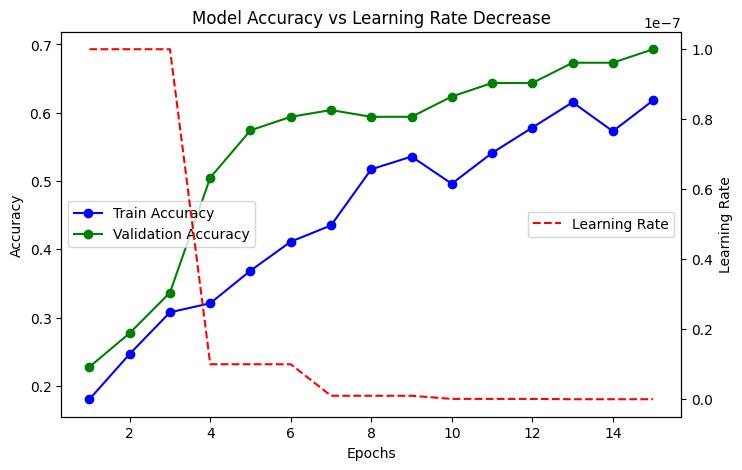

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Extract accuracy and validation accuracy from training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract learning rates used at each epoch
lrs = [K.get_value(mobilenet_skin_model.optimizer.learning_rate)]  
for i in range(1, len(history.epoch)):  
    lrs.append(lrs[-1] * 0.1 if (i % 3 == 0 and i > 0) else lrs[-1])  # Simulating ReduceLROnPlateau effect

epochs = np.arange(1, len(accuracy) + 1)

# Plot Model Accuracy vs Learning Rate
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy curve
ax1.plot(epochs, accuracy, 'b-o', label='Train Accuracy')
ax1.plot(epochs, val_accuracy, 'g-o', label='Validation Accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Accuracy vs Learning Rate Decrease")
ax1.legend(loc="center left")

# Plot learning rate on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, lrs, 'r--', label='Learning Rate')
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="center right")

plt.show()

Generating confusion matrix...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 917ms/step


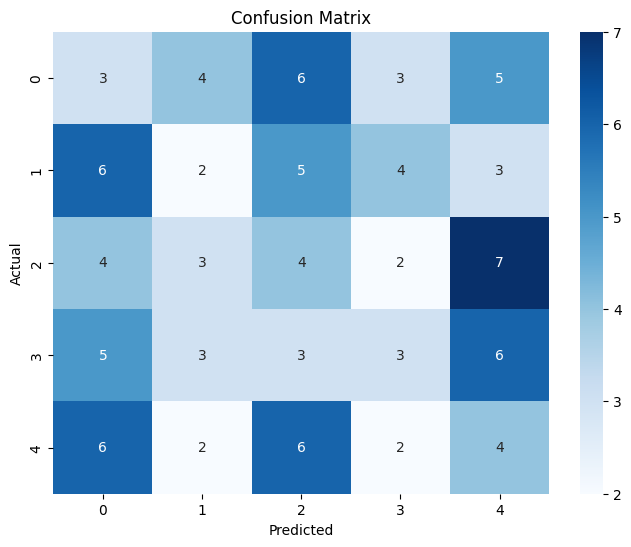

Script execution completed successfully!


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
print("Generating confusion matrix...")
y_pred = np.argmax(mobilenet_skin_model.predict(test_generator), axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Script execution completed successfully!")

### > Save the model

In [20]:
# Save the model
mobilenet_skin_model.save("mobilenet_skin_model.h5")

## -> Model Testing

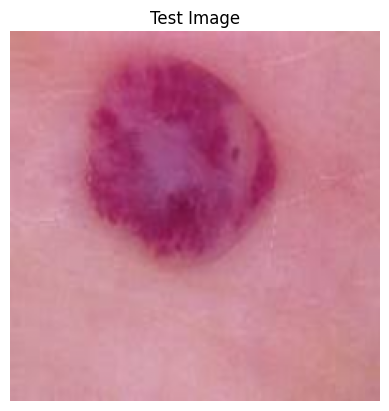

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Vascular Lesion
Confidence: 74.56%


In [21]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/mobilenet_skin_model.h5"
skin_model = load_model(model_path)

# Define class labels (Update according to your dataset)
class_labels = ["Atopic Dermatitis", "Melanoma", "Squamous Cell Carcinoma", "Tinea Ringworm Candidiasis", "Vascular Lesion"]

# Load and preprocess the image
image_path = "/kaggle/input/skin-disease-test-data/skin_data_test/vascular_2.jpeg"  # Update with your image path
img = cv2.imread(image_path)  # Read as RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match MobileNet input
img = img / 255.0  # Normalize pixel values (0-1)
img = np.expand_dims(img, axis=0)  # Add batch dimension → (1, 224, 224, 3)

# Display the image
plt.imshow(img[0])  # Show the first (only) image in batch
plt.axis("off")
plt.title("Test Image")
plt.show()

# Predict using the model
prediction = skin_model.predict(img)
predicted_class = np.argmax(prediction)  # Get the class with highest probability
confidence = np.max(prediction) * 100  # Get confidence score

# Print the results
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")